# Chest X-Ray Classification (LeNet-5 Model)
### Authors: Philipp Gaissert, Sangik Han, Amar Mohanty, Byunghui Yoon

Adapted from the implementation described in TowardsDataScience article "Implementing Yann LeCun's LeNet-5 in PyTorch"
https://towardsdatascience.com/implementing-yann-lecuns-lenet-5-in-pytorch-5e05a0911320

In [ ]:
!pip install torch torchvision

import numpy as np
from datetime import datetime

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, Subset
from torch.utils.data.sampler import WeightedRandomSampler
from torchvision import datasets, transforms
from torchvision.utils import make_grid

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, roc_curve, auc, f1_score

import seaborn as sn
import pandas as pd

import matplotlib.pyplot as plt

from PIL import Image
from google.colab import drive, files
from pathlib import Path
import zipfile
import os
import random
random.seed(0)

In [ ]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Download the Dataset 

In [ ]:
!pip install -q kaggle

data_dir = Path("/content/chest_xray")

if not data_dir.is_dir():

  kaggle_file = Path("/content/kaggle.json")

  while not kaggle_file.is_file():
    files.upload()

  moved_kaggle_file = Path("~/.kaggle/kaggle.json")

  if not moved_kaggle_file.is_file():
    !mkdir -p ~/.kaggle
    !cp /content/kaggle.json ~/.kaggle/kaggle.json
    !ls ~/.kaggle
    !chmod 600 ~/.kaggle/kaggle.json

  # Download the dataset
  !kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

  #Extract the zipfile that is just downloaded. This may take a while.
  with zipfile.ZipFile("chest-xray-pneumonia.zip","r") as z:
    z.extractall(".")

# Data Exploration

In [ ]:
mainDIR = os.listdir('chest_xray')

train_folder= 'chest_xray/train/'
valid_folder = 'chest_xray/val/'
test_folder = 'chest_xray/test/'

train_norm = train_folder+'NORMAL/'
train_pneu = train_folder+'PNEUMONIA/'

valid_norm = valid_folder+'NORMAL/'
valid_pneu = valid_folder+'PNEUMONIA/'

test_norm = test_folder+'NORMAL/'
test_pneu = test_folder+'PNEUMONIA/'

Text(0.5, 1.0, 'Image Set Sizes')

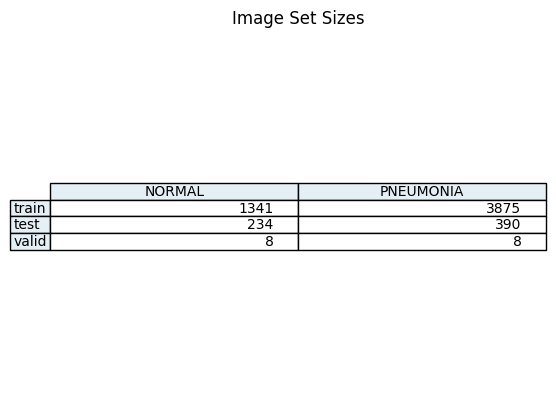

In [ ]:
imgsets = ["train", "test", "valid"]
labels = ["_norm", "_pneu"]

dataset_sizes = {}
cell_text = []

for dataset in imgsets:
  sizes = []
  for label in labels:
    subgroup = dataset+label
    size = len(os.listdir(locals()[subgroup]))
    dataset_sizes[subgroup] = size
    sizes.append(size)
  cell_text.append(sizes)


columns = ('NORMAL', 'PNEUMONIA')

rcolors = plt.cm.BuPu(np.full(len(imgsets), 0.1))
ccolors = plt.cm.BuPu(np.full(len(columns), 0.1))

fig, axs = plt.subplots(1, 1)
# axs.axis('tight')
axs.axis('off')
table = plt.table(cellText=cell_text,
                      rowLabels=imgsets,
                      rowColours=rcolors,
                      colColours=ccolors,
                      colLabels=columns,
                      loc='center')
plt.title(label="Image Set Sizes")

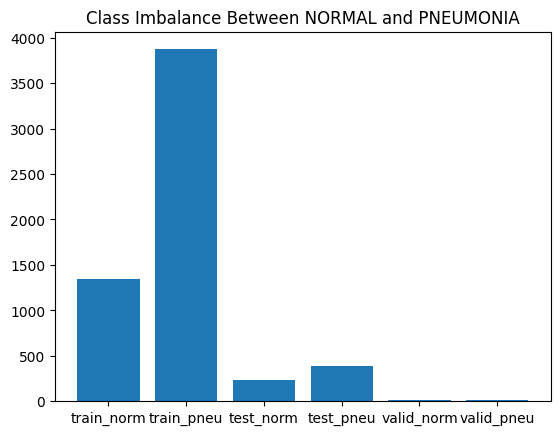

In [ ]:
plt.bar(dataset_sizes.keys(), dataset_sizes.values())
plt.title(label="Class Imbalance Between NORMAL and PNEUMONIA")
plt.show()

Number of normal images: 1341
Number of pneumonia images: 3875
normal picture title:  NORMAL2-IM-1318-0001.jpeg
pneumonia picture title: person637_virus_1218.jpeg


Text(0.5, 1.0, 'PNEUMONIA Example')

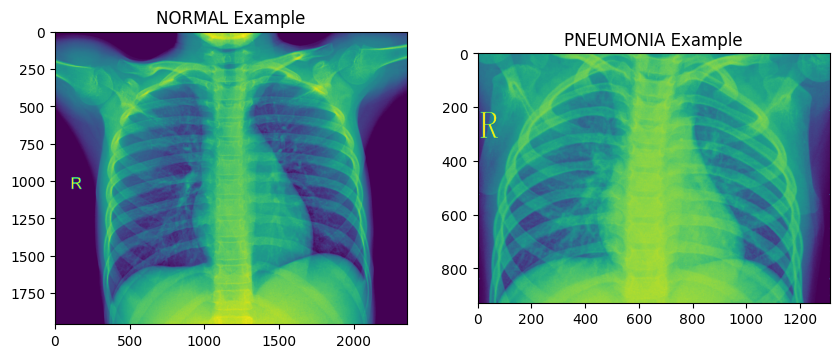

In [ ]:
print(f"Number of normal images: {len(os.listdir(train_norm))}")
print(f"Number of pneumonia images: {len(os.listdir(train_pneu))}")

# Normal
norm_pic = os.listdir(train_norm)[0]
norm_pic_address = train_norm + norm_pic
print('normal picture title: ',norm_pic)

# Pneumonia
pneu_pic =  os.listdir(train_pneu)[0]
pneu_pic_address = train_pneu + pneu_pic
print('pneumonia picture title:', pneu_pic)

# Load the images
norm_load = Image.open(norm_pic_address)
pneu_load = Image.open(pneu_pic_address)

#Let's plt these images
f = plt.figure(figsize= (10,6))
a1 = f.add_subplot(1,2,1)
img_plot = plt.imshow(norm_load)
a1.set_title('NORMAL Example')

a2 = f.add_subplot(1, 2, 2)
img_plot = plt.imshow(pneu_load)
a2.set_title('PNEUMONIA Example')

# Training Helper Functions

In [ ]:
def train(train_loader, model, criterion, optimizer, device):
  '''
  Handles the training step of a single epoch

  Args:
    train_loader: PyTorch DataLoader object for the training set
    model: PyTorch CNN model
    criterion: PyTorch loss criterion to be used
    optimizer: PyTorch optimizer to be used
    device: Name of device to be used, i.e. "cuda" or "cpu"
  Returns:
    model: Updated CNN model
    optimizer: Updated optimizer
    epoch_loss: Training loss for the current epoch
  '''

  model.train()
  running_loss = 0
  
  for X, y_true in train_loader:

    optimizer.zero_grad()

    X = X.to(device)
    y_true = y_true.to(device)

    # Forward Pass - Get predictions for the batch using the current weights
    y_hat, _ = model(X)

    # Calculate the value of the loss function
    loss = criterion(y_hat, y_true)
    running_loss += loss.item() * X.size(0)

    # Backward Pass - Adjust weights based on the loss
    loss.backward()
    optimizer.step()

  epoch_loss = running_loss / len(train_loader.dataset)
  return model, optimizer, epoch_loss

def validate(valid_loader, model, criterion, device):
  '''
  Handles the validation step of a single epoch

  Args:
    valid_loader: PyTorch DataLoader object for the validation set
    model: PyTorch CNN model
    criterion: PyTorch loss criterion to be used
    device: Name of device to be used, i.e. "cuda" or "cpu"
  Returns:
    model: CNN model
    optimizer: Optimizer
    epoch_loss: Validation loss for the current epoch
  '''

  model.eval()
  running_loss = 0

  for X, y_true in valid_loader:

    X = X.to(device)
    y_true = y_true.to(device)

    # Forward Pass
    y_hat, _ = model(X)

    loss = criterion(y_hat, y_true)
    running_loss += loss.item() * X.size(0)

  epoch_loss = running_loss / len(valid_loader.dataset)
  return model, epoch_loss


def get_accuracy(model, data_loader, device):
  '''
  Computes the accuracy of the CNN model on the given dataset

  Args:
    model: PyTorch CNN model
    data_loader: PyTorch DataLoader object for a dataset
    device: Name of device to be used, i.e. "cuda" or "cpu"
  Returns:
    Classification accuracy
  '''

  correct_pred = 0
  n = 0

  with torch.no_grad():
    model.eval()
    for X, y_true in data_loader:

      X = X.to(device)
      y_true = y_true.to(device)

      _, y_prob = model(X)
      _, predicted_labels = torch.max(y_prob, 1)

      n += y_true.size(0)
      correct_pred += (predicted_labels == y_true).sum()

  return correct_pred.float() / n

def plot_losses(train_losses, valid_losses):
  '''
  Plots the training and validation loss over epochs
  '''

  plt.style.use('seaborn')

  train_losses = np.array(train_losses)
  valid_losses = np.array(valid_losses)

  fig, ax = plt.subplots(figsize = (8, 4.5))

  ax.plot(train_losses, color='blue', label='Training Loss')
  ax.plot(valid_losses, color='red', label='Validation Loss')
  ax.set(title="Cross-Entropy Loss Over Epochs", 
         xlabel='Epoch',
         ylabel='Loss') 
  ax.legend()
  fig.show()
  
  # change the plot style to default
  plt.style.use('default')
  plt.savefig("LeNet_LossOverEpochs.png", dpi=300)

def plot_accuracies(train_accs, valid_accs):
  '''
  Plots the training and validation accuracy over epochs
  '''

  plt.style.use('seaborn')

  train_accs = np.array(train_accs)
  valid_accs = np.array(valid_accs)

  fig, ax = plt.subplots(figsize = (8, 4.5))

  ax.plot(train_accs, color='blue', label='Training Accuracy')
  ax.plot(valid_accs, color='red', label='Validation Accuracy')
  ax.set(title="Classification Accuracy Over Epochs", 
         xlabel='Epoch',
         ylabel='Accuracy') 
  ax.legend()
  fig.show()
  
  # change the plot style to default
  plt.style.use('default')
  plt.savefig("LeNet_AccuracyOverEpochs.png", dpi=300)


# Main Training Loop

In [ ]:
def training_loop(model, criterion, optimizer, train_loader, valid_loader, epochs, device, print_every=1):
  '''
  Trains the LeNet-5 model

  Args:
    model: PyTorch CNN model
    criterion: PyTorch loss criterion to be used
    optimizer: PyTorch optimizer to be used
    train_loader: PyTorch DataLoader object for the training set
    valid_loader: PyTorch DataLoader object for the validation set
    epochs: Number of training epochs
    device: Name of device to be used, i.e. "cuda" or "cpu"
    print_every: How often accuracy and loss should be printed during training
  Returns:
    model: Trained CNN model
    optimizer: Updated optimizer
    (train_losses, valid_losses): Lists of training losses and validation losses over epochs
  '''


  # Set objects for storing metrics
  best_loss = 1e10
  train_losses = []
  valid_losses = []
  train_accs = []
  valid_accs = []
  # Training Loop
  for epoch in range(epochs):

    # Training Step
    model, optimizer, train_loss = train(train_loader, model, criterion, optimizer, device)
    train_losses.append(train_loss)

    # Validation Step
    with torch.no_grad(): 
      model, valid_loss = validate(valid_loader, model, criterion, device)
      valid_losses.append(valid_loss)

    if epoch % print_every == (print_every - 1):

      train_acc = get_accuracy(model, train_loader, device=device)
      valid_acc = get_accuracy(model, valid_loader, device=device)

      train_accs.append(train_acc)
      valid_accs.append(valid_acc)

      print(f'{datetime.now().time().replace(microsecond=0)} --- '
            f'Epoch: {epoch}\t'
            f'Train loss: {train_loss:.4f}\t'
            f'Valid loss: {valid_loss:.4f}\t'
            f'Train accuracy: {100 * train_acc:.2f}\t'
            f'Valid accuracy: {100 * valid_acc:.2f}')
    
  plot_losses(train_losses, valid_losses)
  plot_accuracies(train_accs, valid_accs)

  return model, optimizer, (train_losses, valid_losses)

## LeNet-5 Architecture (Original)

**Input Size:** 32 x 32 x 1 (Grayscale)

1. **Convolution (C1)**
  - **Filter Size:** 5 x 5
  - **# of Filters:** 6
  - **Stride:** 1
  - **Padding:** 0
  - **Activation:** Hyperbolic Tangent (tanh)
  - **Output Size:** 28 x 28 x 6
2. **Subsampling (S2)**
  - **Type:** Custom Pooling
  - **Filter Size:** 2 x 2
  - **Stride:** 2
  - **Padding:** 0
  - **Output Size:** 14 x 14 x 6
3. **Convolution (C3)**
  - **Filter Size:** 5 x 5
  - **# of Filters:** 16
  - **Stride:** 1
  - **Padding:** 0
  - **Activation:** Hyperbolic Tangent (tanh)
  - **Output Size:** 10 x 10 x 16
4. **Subsampling (S4)**
  - **Type:** Custom Pooling
  - **Filter Size:** 2 x 2
  - **Stride:** 2
  - **Padding:** 0
  - **Output Size:** 5 x 5 x 6
5. **Convolution (C5)**
  - **Filter Size:** 5 x 5
  - **# of Filters:** 120
  - **Stride:** N/A
  - **Padding:** 0
  - **Activation:** Hyperbolic Tangent (tanh)
  - **Output Size:** 1 x 1 x 120
6. **Fully-Connected (F6)**
  - **Inputs:** 120
  - **Activation:** Hyperbolic Tangent (tanh)
  - **Outputs:** 84
7. **Fully Connectied (F7)**
  - **Inputs:** 84
    - The weights represent a 7 x 12 binary mask (one for each digit)
    - Forces the network to transform the input image into an internal representation
  - **Activation:** Euclidean Radial Basis Function
  - **Outputs:** 10 (digits 0-9)
  

## LeNet-5 Architecture (Adapted)

**Pre-processing**
  - Random Augmentations (training set only)
    - Rotation ± 10 deg
    - Equalization
  - Resize to `RESIZE` pixels (on shortest side)
  - Center-crop to 224 x 224
  - Convert to tensors

**Input Size:** 224 x 224 x 3 (RGB)

**Layers**
1. **Subsampling (S1)**
  - **Type:** Max Pooling
  - **Filter Size:** 2 x 2
  - **Stride:** 2
  - **Padding:** 0
  - **Output Size:** 112 x 112 x 3
2. **Subsampling (S2)**
  - **Type:** Max Pooling
  - **Filter Size:** 2 x 2
  - **Stride:** 2
  - **Padding:** 0
  - **Output Size:** 56 x 56 x 3
3. **Subsampling (S3)**
  - **Type:** Max Pooling
  - **Filter Size:** 2 x 2
  - **Stride:** 2
  - **Padding:** 0
  - **Output Size:** 28 x 28 x 3
4. **Convolution (C4)**
  - **Filter Size:** 5 x 5
  - **# of Filters:** 6
  - **Stride:** 1
  - **Padding:** 2
  - **Activation:** Hyperbolic Tangent (tanh)
  - **Output Size:** 28 x 28 x 6
5. **Subsampling (S5)**
  - **Type:** Average Pooling
  - **Filter Size:** 2 x 2
  - **Stride:** 2
  - **Padding:** 0
  - **Output Size:** 14 x 14 x 6
6. **Convolution (C6)**
  - **Filter Size:** 5 x 5
  - **# of Filters:** 16
  - **Stride:** 1
  - **Padding:** 0
  - **Activation:** Hyperbolic Tangent (tanh)
  - **Output Size:** 10 x 10 x 16
7. **Subsampling (S7)**
  - **Type:** Average Pooling
  - **Filter Size:** 2 x 2
  - **Stride:** 2
  - **Padding:** 0
  - **Output Size:** 5 x 5 x 6
8. **Convolution (C8)**
  - **Filter Size:** 5 x 5
  - **# of Filters:** 120
  - **Stride:** N/A
  - **Padding:** 0
  - **Activation:** Hyperbolic Tangent (tanh)
  - **Output Size:** 1 x 1 x 120
9. **Fully Connected (F9)**
  - **Inputs:** 120
  - **Activation:** Hyperbolic Tangent (tanh)
  - **Outputs:** 84
10. **Fully-Connected (F10)**
  - **Inputs:** 84
  - **Activation:** Softmax
  - **Outputs:** `N_CLASSES`
  

# LeNet5 Implementation

See previous cell for the details of each layer

In [ ]:
class LeNet5(nn.Module):
  '''
  Implementation of LeNet-5 architecture, adapted for our dataset
  '''
  def __init__(self, n_classes):
    super(LeNet5, self).__init__()

    # Hidden Layers
    self.feature_extractor = nn.Sequential(                                           ## LAYER NAME
                                           
        nn.MaxPool2d(kernel_size=2, stride=2),                                         # S1
        nn.MaxPool2d(kernel_size=2, stride=2),                                         # S2
        nn.MaxPool2d(kernel_size=2, stride=2),                                         # S3

        nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1, padding=2),  # C4
        nn.Tanh(), # tanh activation

        nn.AvgPool2d(kernel_size=2),                                                   # S5

        nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),            # C6
        nn.Tanh(), # tanh activation
        
        nn.AvgPool2d(kernel_size=2),                                                   # S7
        nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1),          # C8
        nn.Tanh(), # tanh activation
    )

    # Fully-Connected Layers
    self.classifier = nn.Sequential(
        nn.Linear(in_features=120, out_features=84),                                   # F9
        nn.Tanh(), # tanh activation

        nn.Linear(in_features=84, out_features=n_classes),                             # F10
    )

  def forward(self, x):
    x = self.feature_extractor(x)
    x = torch.flatten(x, 1)
    logits = self.classifier(x)
    probs = F.softmax(logits, dim=1) # softmax for cross-entropy loss
    return logits, probs

# Hyperparameters & Other Variables

In [ ]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
RANDOM_SEED = 42

# Hyperparameters
ROTATION = 10            # Maximum number of degrees of random rotation
IMG_RESIZE = 230         # Shortest side of images post-resizing (pre-center-cropping to 224)
LEARNING_RATE = 0.0001
VALID_SIZE = 0.1
BATCH_SIZE = 50
N_EPOCHS = 12
N_CLASSES = 2

# Data Preparation & Class Balancing

In [ ]:
# https://stackoverflow.com/questions/67799246/weighted-random-sampler-oversample-or-undersample
def make_weights_for_balanced_classes(images, nclasses):
  '''
  Computes a class-based sampling weight for each image

  Args:
    images: List of images, as tuples (filepath, class)
    nclasses: Number of classses

  Return:
    weight: List of class-based weights for each image
  '''
  count = [0] * nclasses                                                      
  for item in images:                                                         
      count[item[1]] += 1                                                     
  weight_per_class = [0.] * nclasses                                      
  N = float(sum(count))                                                   
  for i in range(nclasses):                                                   
      weight_per_class[i] = N/float(count[i])                                 
  weight = [0] * len(images)                                              
  for idx, val in enumerate(images):                                          
      weight[idx] = weight_per_class[val[1]]                                  
  return weight                        

In [ ]:
class DatasetFromSubset(Dataset):
  '''
  For assigning unique transformers to Subset made from the same Dataset
  '''
  def __init__(self, subset, transform=None):
      self.subset = subset
      self.transform = transform
      self.imgs = [subset.dataset.imgs[i] for i in subset.indices]
      self.classes = subset.dataset.classes

  def __getitem__(self, index):
      x, y = self.subset[index]
      if self.transform:
          x = self.transform(x)
      return x, y

  def __len__(self):
      return len(self.subset)

In [ ]:
torch.manual_seed(RANDOM_SEED)

# Transformer for the training set
# - includes random augmentations
train_transformer = transforms.Compose([transforms.RandomRotation(ROTATION),
                                        transforms.RandomEqualize(),
                                        transforms.Resize(IMG_RESIZE),
                                        transforms.CenterCrop(224),
                                        transforms.ToTensor(),
                                      ])

# Transformer for the validation and testing sets
test_transformer = transforms.Compose([transforms.Resize(IMG_RESIZE),
                                       transforms.CenterCrop(224),
                                       transforms.ToTensor(),
                                      ])

# Load the dataset from the training folder
dataset = datasets.ImageFolder(root=train_folder)

# Do a stratified subsampling of the training images to split it into training set and validation set
# - Reference: https://linuxtut.com/en/c6023453e00bfead9e9f/
train_indices, valid_indices = train_test_split(list(range(len(dataset.targets))), test_size=VALID_SIZE, stratify=dataset.targets)
train_dataset = DatasetFromSubset(Subset(dataset, train_indices), transform=train_transformer)
valid_dataset = DatasetFromSubset(Subset(dataset, valid_indices), transform=test_transformer)

# Compute the sampling weights for the images in the training and validation sets
train_weights = torch.DoubleTensor(make_weights_for_balanced_classes(train_dataset.imgs, len(train_dataset.classes)))
valid_weights = torch.DoubleTensor(make_weights_for_balanced_classes(valid_dataset.imgs, len(valid_dataset.classes)))

# Give the weights to WeightedRandomSampler objects, for handling class imbalance
train_weighted_sampler = WeightedRandomSampler(train_weights, len(train_weights), generator=torch.Generator().manual_seed(RANDOM_SEED))
valid_weighted_sampler = WeightedRandomSampler(valid_weights, len(valid_weights), generator=torch.Generator().manual_seed(RANDOM_SEED))

# Create the DataLoader objects for the training and validation sets
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, pin_memory=True, sampler=train_weighted_sampler)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=BATCH_SIZE, pin_memory=True, sampler=valid_weighted_sampler)

# Confirm the stratified subsampling
train_norm_count = sum(map(lambda x : x[1] == 0, train_dataset.imgs))
train_pneu_count = sum(map(lambda x : x[1] == 1, train_dataset.imgs))

valid_norm_count = sum(map(lambda x : x[1] == 0, valid_dataset.imgs))
valid_pneu_count = sum(map(lambda x : x[1] == 1, valid_dataset.imgs))

print("TRAINING SET")
print(f"\tNORMAL:    {train_norm_count} ({train_norm_count / len(train_dataset.imgs) * 100}%)")
print(f"\tPNEUMONIA: {train_pneu_count} ({train_pneu_count / len(train_dataset.imgs) * 100}%)")
print("VALIDATION SET")
print(f"\tNORMAL:    {valid_norm_count} ({valid_norm_count / len(valid_dataset.imgs) * 100}%)")
print(f"\tPNEUMONIA: {valid_pneu_count} ({valid_pneu_count / len(valid_dataset.imgs) * 100}%)")

TRAINING SET
	NORMAL:    1207 (25.713677034512145%)
	PNEUMONIA: 3487 (74.28632296548786%)
VALIDATION SET
	NORMAL:    134 (25.67049808429119%)
	PNEUMONIA: 388 (74.32950191570882%)


In [ ]:
def show_batch(data_loader, set_name):
  for images, labels in data_loader:
    fig, ax = plt.subplots(figsize=(15, 15))
    ax.imshow(make_grid(images[:50], nrow=10).permute(1, 2, 0))
    plt.title(f"Example Batch from {set_name}")
    break

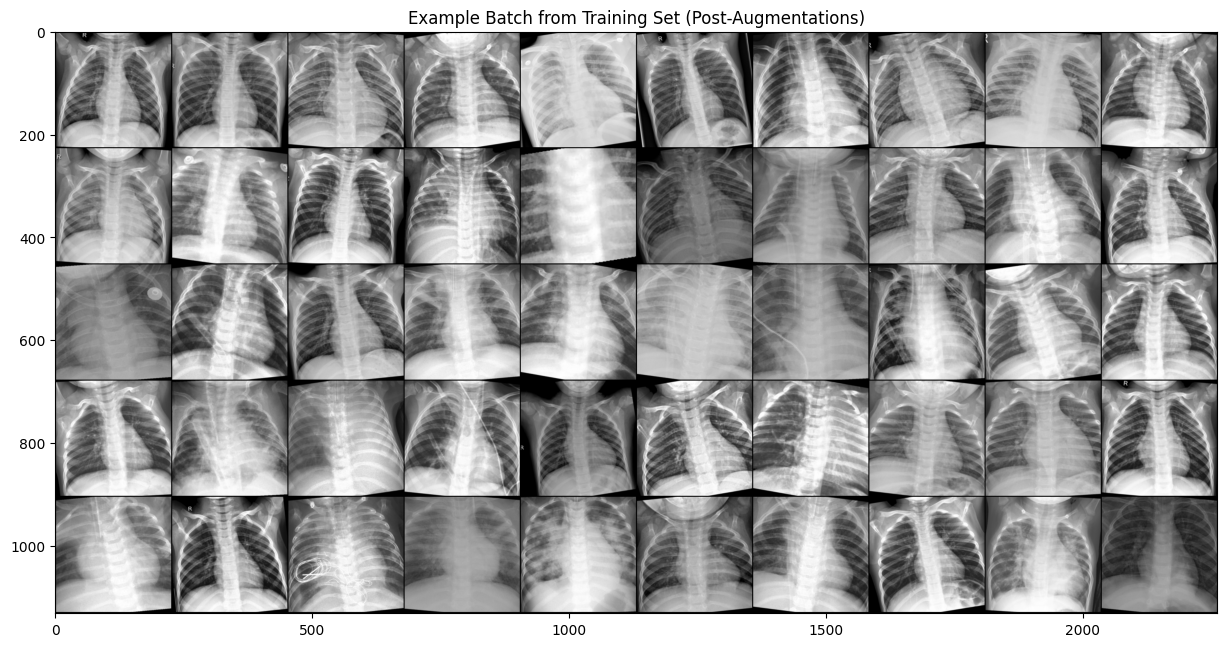

In [ ]:
show_batch(train_loader, "Training Set (Post-Augmentations)")

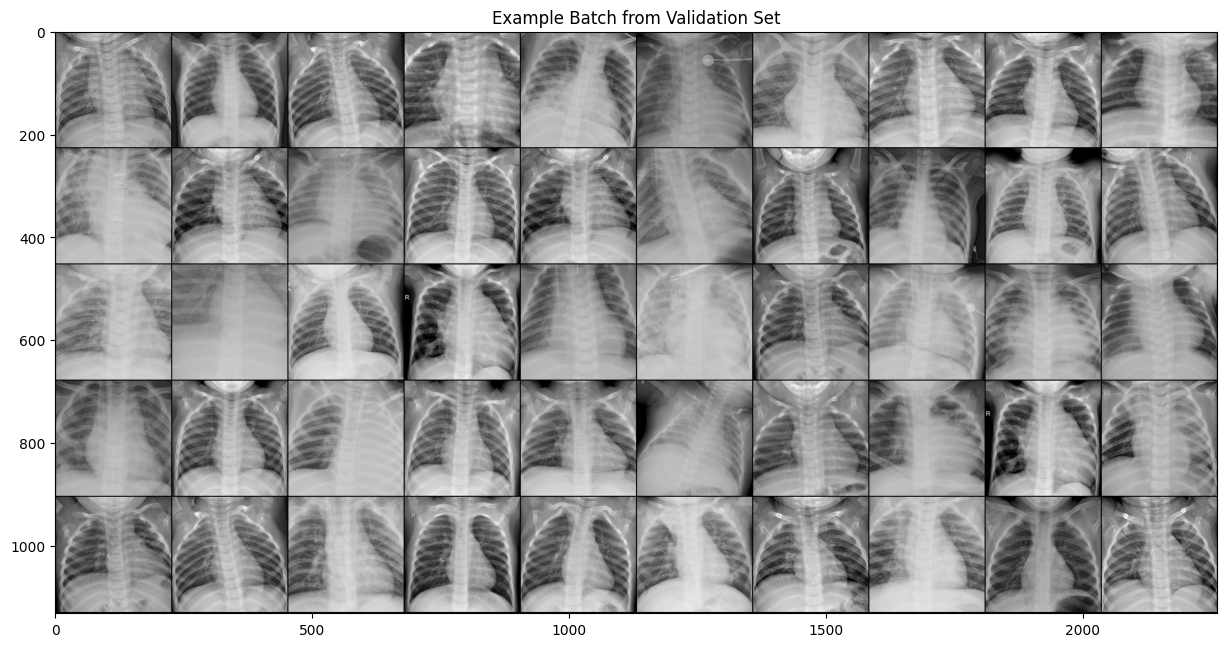

In [ ]:
show_batch(valid_loader, "Validation Set")

# Train the Model

In [ ]:
model = LeNet5(N_CLASSES).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

23:31:37 --- Epoch: 0	Train loss: 0.6686	Valid loss: 0.6240	Train accuracy: 80.83	Valid accuracy: 77.59
23:37:14 --- Epoch: 1	Train loss: 0.4340	Valid loss: 0.2801	Train accuracy: 90.71	Valid accuracy: 90.61
23:42:45 --- Epoch: 2	Train loss: 0.2699	Valid loss: 0.1895	Train accuracy: 90.43	Valid accuracy: 94.25
23:48:11 --- Epoch: 3	Train loss: 0.2303	Valid loss: 0.2147	Train accuracy: 91.37	Valid accuracy: 92.34
23:53:40 --- Epoch: 4	Train loss: 0.2231	Valid loss: 0.1982	Train accuracy: 90.88	Valid accuracy: 92.34
23:59:18 --- Epoch: 5	Train loss: 0.2149	Valid loss: 0.2031	Train accuracy: 91.95	Valid accuracy: 94.83
00:05:01 --- Epoch: 6	Train loss: 0.2173	Valid loss: 0.1899	Train accuracy: 92.12	Valid accuracy: 93.68
00:10:36 --- Epoch: 7	Train loss: 0.1934	Valid loss: 0.1478	Train accuracy: 93.31	Valid accuracy: 94.44
00:16:11 --- Epoch: 8	Train loss: 0.1904	Valid loss: 0.1919	Train accuracy: 93.05	Valid accuracy: 95.40
00:21:47 --- Epoch: 9	Train loss: 0.1741	Valid loss: 0.2052	Trai

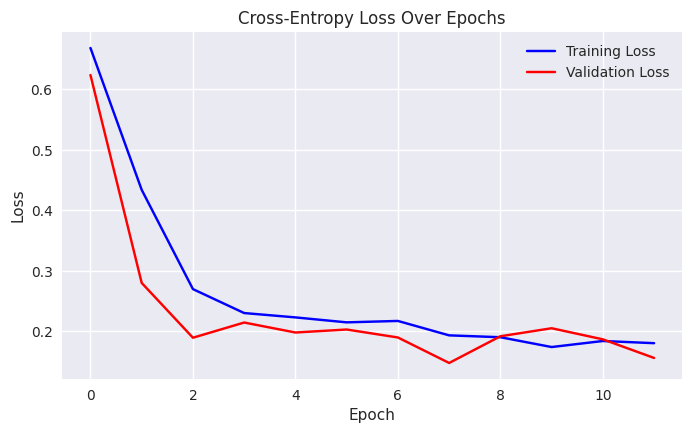

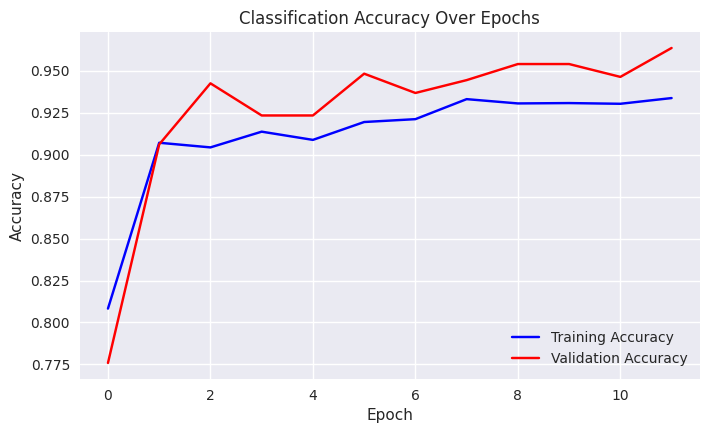

In [ ]:
model, optimizer, _ = training_loop(model, criterion, optimizer, train_loader, valid_loader, N_EPOCHS, DEVICE)

# Evaluation Helper Functions

In [ ]:
def create_cf_matrix(model, data_loader, device):
  '''
  Creates a confusion matrix
  Adapted from: https://christianbernecker.medium.com/how-to-create-a-confusion-matrix-in-pytorch-38d06a7f04b7

  Args:
    model: Trained PyTorch CNN model
    data_loader: PyTorch DataLoader object for a dataset
    device: Name of device to be used, i.e. "cuda" or "cpu"

  Return:
    cf_matrix: Confusion matrix
    
  '''
  y_pred = []
  y_true = []

  with torch.no_grad():
    model.eval()

    for inputs, labels in data_loader:

      inputs = inputs.to(device)
      labels = labels.to(device)

      _, probs = model(inputs)
      _, output = torch.max(probs, 1)

      output = output.data.cpu().numpy()
      y_pred.extend(output)

      labels = labels.data.cpu().numpy()
      y_true.extend(labels)

  

  cf_matrix = confusion_matrix(y_true, y_pred)

  return cf_matrix, y_true, y_pred

def plot_cf_matrix(cf_matrix, classes, set_name):
  '''
  Plots a confusion matrix

  Args:
    cf_matrix: Confusion matrix
    classes: List of class names, in order of y label
  '''

  df_cm = pd.DataFrame(cf_matrix , index = [i for i in classes], columns = [i for i in classes])

  plt.figure(figsize=(12,7))
  ax = sn.heatmap(df_cm, annot=True, fmt="d")
  # ax.xaxis.tick_top()
  plt.tick_params(axis='both', which='major', labelsize=10, labelbottom=False, bottom=False, top=False, left=False, labeltop=True)
  ax.xaxis.set_label_position("top")
  plt.title(f"Confusion Matrix ({set_name})")

  tp = cf_matrix[1][1]
  fp = cf_matrix[0][1]

  tn = cf_matrix[0][0]
  fn = cf_matrix[1][0]

  accuracy = (tp + tn) / (tp + fp + tn + fn)
  precision = tp / (tp + fp)
  recall = tp / (tp + fn)
  specificity = tn / (tn + fp)
  f1 = 2 * precision * recall / (precision + recall)

  print(f"Accuracy: {accuracy}")
  print(f"Precision: {precision}")
  print(f"Recall: {recall}")
  print(f"Specificity: {specificity}")
  print(f"F1: {f1}")

def plot_roc(y_true, y_pred, set_name):
  '''
  Plots the ROC curve
  Adapted from https://discuss.pytorch.org/t/roc-curves-for-a-simple-cnn-multi-class-model/98069/2

  Args:
    y_true: List of true labels
    y_pred: List of predicted labels
  '''
  fpr, tpr, thresholds = roc_curve(y_true, y_pred)
  roc_auc = auc(fpr, tpr)

  plt.figure()
  lw = 2
  plt.plot(fpr, tpr, color='darkorange',
          lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
  plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.02])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title(f'Receiver Operating Characteristic curve ({set_name})')
  plt.legend(loc="lower right")
  plt.show()

def display_predictions(dataset, set_name, classes):
  '''
  Displays a grid of example images with their predicted labels and true labels
  '''

  fig = plt.figure(figsize=(10, 10))

  ROW_IMG = 5
  N_ROWS = 5

  img_idxs = random.sample(range(len(dataset.imgs)), 25)

  for index in range(0, ROW_IMG * N_ROWS):
    plt.subplot(N_ROWS, ROW_IMG, index + 1)
    img_idx = img_idxs[index]
    plt.axis('off')
    plt.imshow(dataset[img_idx][0].numpy().squeeze().transpose(1, 2, 0))
    
    with torch.no_grad():
        model.eval()
        _, probs = model(dataset[img_idx][0].cuda().unsqueeze(0))
    title = f'Predicted: {classes[torch.argmax(probs)]} ({torch.max(probs * 100):.0f}%)\nTrue:{classes[dataset.imgs[img_idx][1]]}'
    
    plt.title(title, fontsize=7)

  plt.subplots_adjust(left=0.1,
                      bottom=0.1, 
                      right=0.9, 
                      top=0.9, 
                      wspace=0.4, 
                      hspace=0.4)
  
  fig.suptitle(f'LeNet-5: Example Predictions from {set_name}')

# Evaluate the Model

In [ ]:
# Load the testing dataset from the testing folder
test_dataset = datasets.ImageFolder(root=test_folder, transform=test_transformer)
# Compute the sampling weights for the images in the testing set
test_weights = torch.DoubleTensor(make_weights_for_balanced_classes(test_dataset.imgs, len(test_dataset.classes)))
# Give the weights to WeightedRandomSampler objects, for handling class imbalance
test_weighted_sampler = WeightedRandomSampler(test_weights, len(test_weights), generator=torch.Generator().manual_seed(RANDOM_SEED))
# Create the DataLoader objects for the testing set
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, pin_memory=True, sampler=test_weighted_sampler)

Accuracy: 0.6682692307692307
Precision: 0.6016260162601627
Recall: 0.9641693811074918
Specificity: 0.38170347003154576
F1: 0.7409261576971214


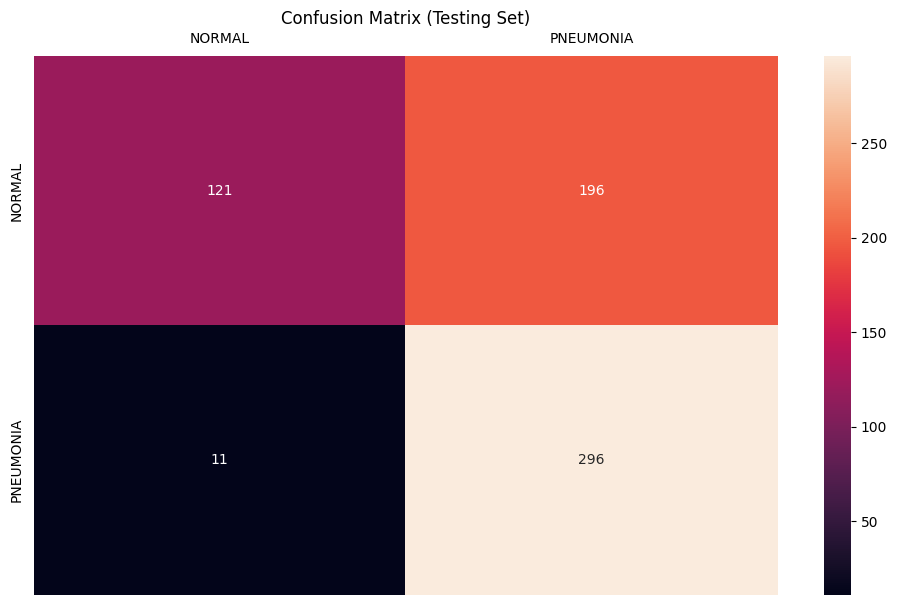

In [ ]:
classes = ('NORMAL', 'PNEUMONIA')
cf_matrix, y_true, y_pred = create_cf_matrix(model, test_loader, DEVICE)
plot_cf_matrix(cf_matrix, classes, "Testing Set")

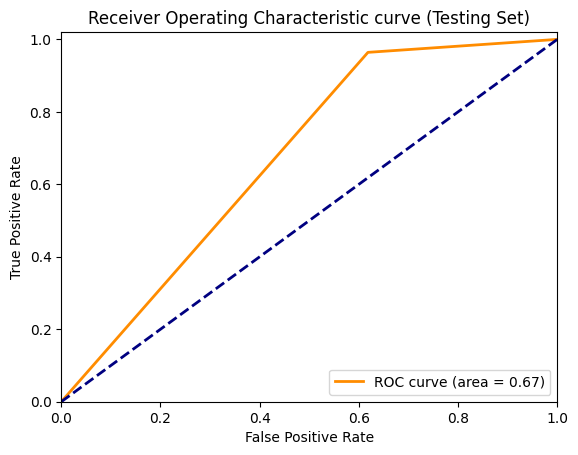

In [ ]:
plot_roc(y_true, y_pred, "Testing Set")

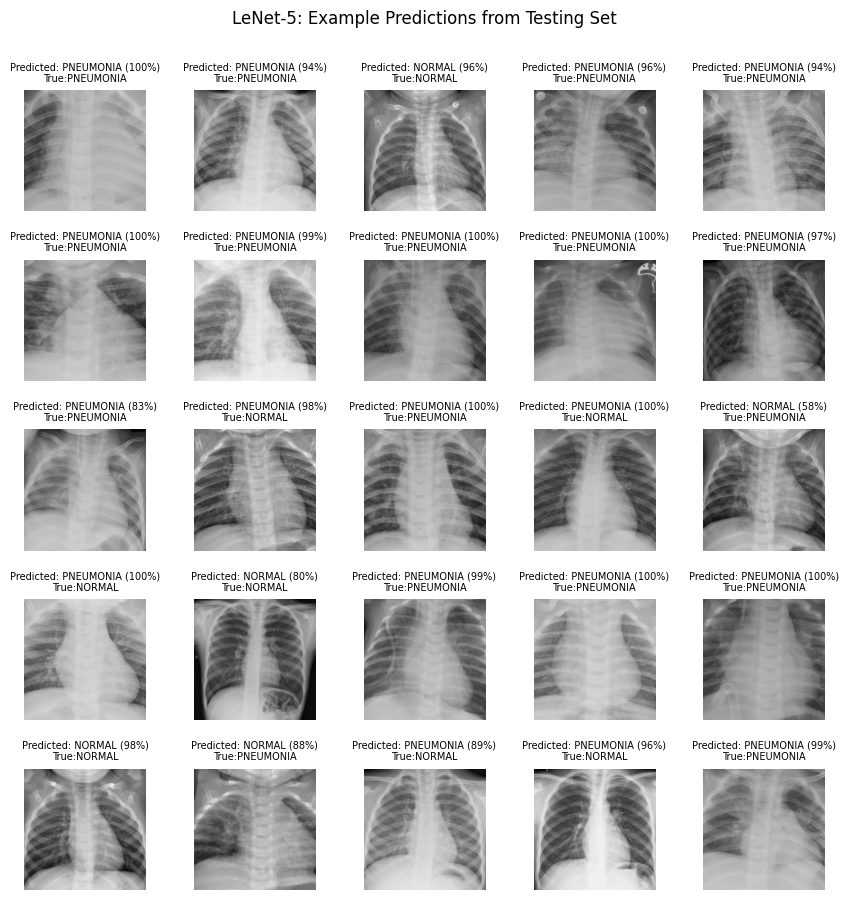

In [ ]:
display_predictions(test_dataset, "Testing Set", classes)